# Exploratory Data Analysis

Here we will explore our dataset to understand how this marketplace works.

## Chapter I - Activity and Ratings

A "rating" denotes how strongly A trusts B. It's directed, timestamped, and it takes integer values between -10 to 10.

In [1]:
from sna_bitcoin_otc.utils.network import get_dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = get_dataframe()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35591 entries, 0 to 35590
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   src_id     35591 non-null  int64  
 1   dest_id    35591 non-null  int64  
 2   rating     35591 non-null  int64  
 3   timestamp  35591 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.1 MB


In [4]:
df["rating"].describe()

count    35591.000000
mean         1.011941
std          3.562109
min        -10.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: rating, dtype: float64

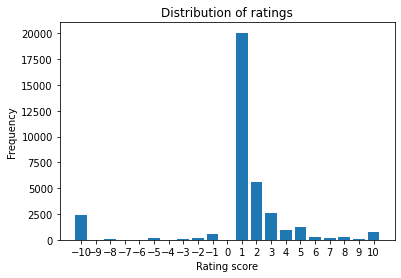

In [5]:
# Distribution of ratings
counts = dict(df["rating"].value_counts())
counts = dict(sorted(counts.items()))

plt.bar(counts.keys(), counts.values())
plt.xticks([*range(-10, 11)])
plt.title("Distribution of ratings")
plt.xlabel("Rating score")
plt.ylabel("Frequency")
plt.show()

This implies that the market tends to vote >=1 at most cases.

The market usually refrains from going to extremes even when they trust someone. However, their distrust usually ends in a -10 vote.

The market **builds trust slowly and step-by-step, but its distrust is extreme and unforgiving.**

### Moving averages of mean and variance of ratings

Since money is a tangible form of trust, "importing" metrics and reasoning used in financial markets would definitely make sense here

In [6]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.head()

,src_id,dest_id,rating,timestamp
0,6,5,2,2010-11-08 18:45:41.533780224
1,1,15,1,2010-11-08 19:05:40.390490112
2,4,3,7,2010-11-08 19:41:17.369750016
3,13,16,8,2010-11-08 22:10:54.447459840
4,13,10,8,2010-11-08 22:11:40.795140096


In [7]:
df_sorted = df.sort_values(by="timestamp")
df_sorted.head()

,src_id,dest_id,rating,timestamp
0,6,5,2,2010-11-08 18:45:41.533780224
1,1,15,1,2010-11-08 19:05:40.390490112
2,4,3,7,2010-11-08 19:41:17.369750016
3,13,16,8,2010-11-08 22:10:54.447459840
4,13,10,8,2010-11-08 22:11:40.795140096


In [8]:
df_sorted.tail()

,src_id,dest_id,rating,timestamp
35586,4499,1810,1,2016-01-24 05:14:41.647290112
35587,2731,3901,5,2016-01-24 23:50:28.049489920
35588,2731,4897,5,2016-01-24 23:50:34.034019840
35589,13,1128,1,2016-01-24 23:53:52.985709824
35590,1128,13,2,2016-01-25 01:12:03.757280000


Data contains votes from November 2010 to January 2016

We will use three moving averages (window=200, window=1000, window=5000) to look for trends in the data

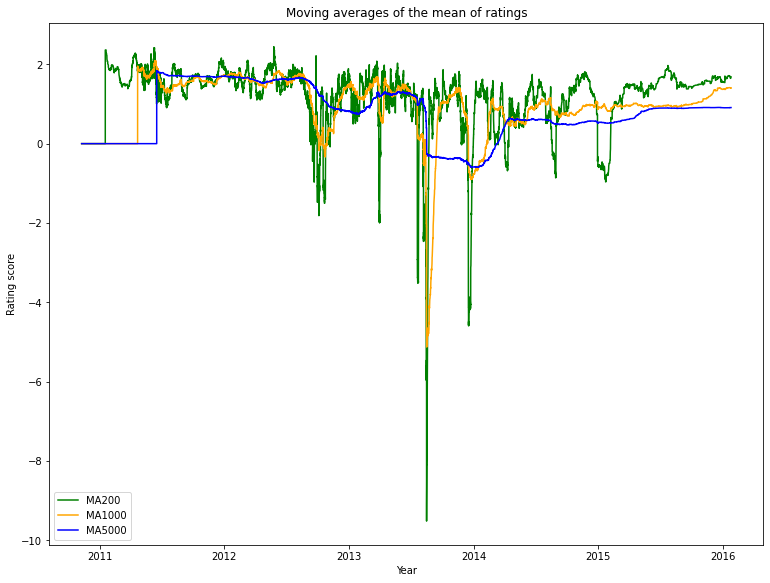

In [9]:
# Moving averages of the mean of ratings
ma200_mean = df['rating'].rolling(window=200).mean().fillna(0)
ma1000_mean = df['rating'].rolling(window=1000).mean().fillna(0)
ma5000_mean = df['rating'].rolling(window=5000).mean().fillna(0)

plt.figure(figsize=(12.8, 9.6))
plt.plot(df["timestamp"], ma200_mean, color="green")
plt.plot(df["timestamp"], ma1000_mean, color="orange")
plt.plot(df["timestamp"], ma5000_mean, color="blue")

plt.title("Moving averages of the mean of ratings")
plt.legend(["MA200", "MA1000", "MA5000"])
plt.ylabel("Rating score")
plt.xlabel("Year")
plt.show()

By looking at moving averages of the mean of the ratings, we can clearly say that there is a significant increase in negative votes at a particular period of time. **The period between late 2012 to 2014 needs more attention.**

Other short term decreases should be investigated as well

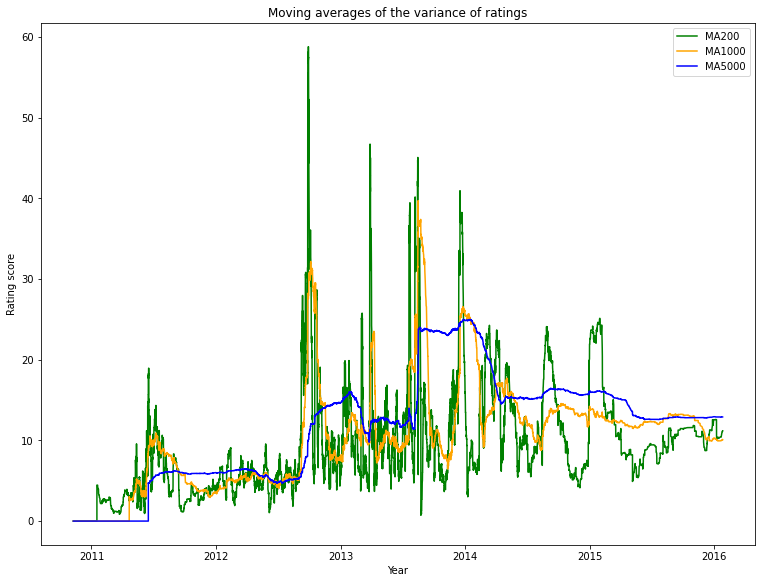

In [10]:
# Moving averages of the variance of the ratings


ma200_var = df['rating'].rolling(window=200).var().fillna(0)
ma1000_var = df['rating'].rolling(window=1000).var().fillna(0)
ma5000_var = df['rating'].rolling(window=5000).var().fillna(0)

plt.figure(figsize=(12.8, 9.6))
plt.plot(df["timestamp"], ma200_var, color="green")
plt.plot(df["timestamp"], ma1000_var, color="orange")
plt.plot(df["timestamp"], ma5000_var, color="blue")

plt.title("Moving averages of the variance of ratings")
plt.legend(["MA200", "MA1000", "MA5000"])
plt.ylabel("Rating score")
plt.xlabel("Year")
plt.show()

As usual, "bear markets" are accompanied with increases in the variance (volatility), which is a clear sign of risk.

This also shows that there is something going wrong especially in the period between late-2012 to 2014.

###  Activity and Mean
Key question: For a time period p, is there a relation between number of activities per p and avg. rating per p?

In [11]:
# activity for each month
grouped = df.groupby(pd.Grouper(key='timestamp', freq='1M')).agg("count") # groupby each 1 month
grouped.index = grouped.index.strftime('%b-%Y')

# mean for each month
grouped_m = df.groupby(pd.Grouper(key='timestamp', freq='1M')).mean()
grouped_m.index = grouped_m.index.strftime('%b-%Y')

# variance for each month
grouped_var = df.groupby(pd.Grouper(key='timestamp', freq='1M')).var()
grouped_var.index = grouped_var.index.strftime('%b-%Y')

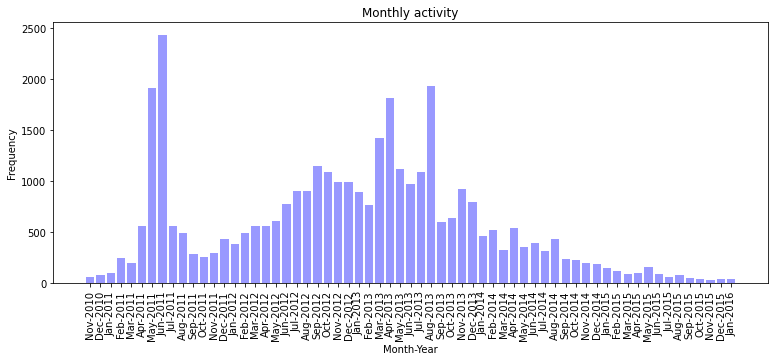

In [12]:
plt.figure(figsize=(12.8, 4.8))
plt.bar(grouped.index, grouped["src_id"], color="blue", alpha=0.4)
plt.xticks(grouped.index, rotation=90)

plt.title("Monthly activity")
plt.ylabel("Frequency")
plt.xlabel("Month-Year")
plt.show()

Let's look at correlation coefficients

In [13]:
r_var = np.corrcoef(grouped["rating"], grouped_var["rating"])[0][1]
r_mean = np.corrcoef(grouped["rating"], grouped_m["rating"])[0][1]
r_meanvar = np.corrcoef(grouped_m["rating"], grouped_var["rating"])[0][1]

print("Corr. Coef. of Activity and Variance(Volatility) of ratings:", r_var)
print("Corr. Coef. of Activity and Mean of ratings:", r_mean)
print("Corr. Coef. of Mean and Variance:", r_meanvar) # this can be visually seen in the plots above as well

Corr. Coef. of Activity and Variance(Volatility) of ratings: 0.2601416792039215
Corr. Coef. of Activity and Mean of ratings: -0.31469229528541215
Corr. Coef. of Mean and Variance: -0.8264991138801941


### Chapter Summary

- The market builds trust slowly and step by step, but its distrust is extreme and unforgiving
- An increase in volatility implies (with a strong correlation) a decrease in avg. ratings
- No correlation between activity and market sentiment (bearish/bullish)
- Decreases in the moving average of mean combined with Increases in the moving average of variance = "Bear market"
    - "Bear market" periods should be investigated, as we expect that most of the fraud rings would be active at those periods
    - The period between late-2012 to 2014 needs more attention, since it's the worst and the longest bear market
- There's a great disinterest 

## Chapter II - Exploring the Network

Now that we've seen the market's voting patterns, and periods to more thoroughly investigate, we can explore the network itself

Some properties
- 5881 nodes, 35591 edges
- Edges are directed and signed weighted
- An example node: (:BTCUser {node_id: 5})
- An example edge (relationship): [:RATED {rating: -5, timestamp: 1835235134}]

In [14]:
from sna_bitcoin_otc.utils.network import get_driver, neo4j_to_nx
import networkx as nx

In [15]:
G = neo4j_to_nx(get_driver("bolt://localhost:11012"))  # Get all nodes and edges

### Visualizing the network and basic analytics
- Neo4j Bloom changes the orientation of edges/nodes sometimes but this doesn't affect the network itself
- Users are the black dots
- Edge colors range is as the following: 
    - Red-Orange(Leaning negative) => Yellow-Green(Moderate) => Green-Blue(Leaning positive)

**Visualizing the whole graph - Notice the red area**

![](assets/bloom_whole_graph.PNG)

**Visualizing nodes involved in edges < 0 (i.e. people accusing each other of fraud)**

![](assets/bloom_reports_network.PNG)

**Let's look at some descriptive statistics**

Distribution of degrees

count    5881.000000
mean        6.051862
std        17.674750
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       535.000000
dtype: float64


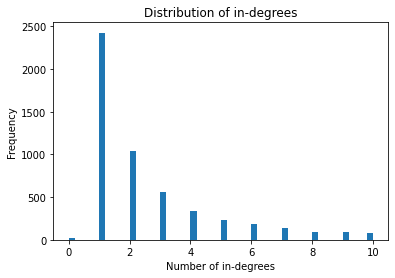

In [16]:
in_degrees = [G.in_degree(node) for node in G.nodes()]

print(pd.Series(in_degrees).describe())

plt.title("Distribution of in-degrees")
plt.xlabel("Number of in-degrees")
plt.ylabel("Frequency")
plt.hist(in_degrees, bins=50, range=(0, 10))
plt.show()

count    5881.000000
mean        6.051862
std        21.088118
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       763.000000
dtype: float64


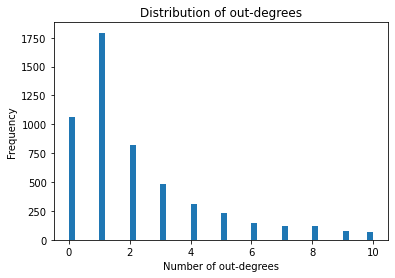

In [17]:
out_degrees = [G.out_degree(node) for node in G.nodes()]

print(pd.Series(out_degrees).describe())

plt.title("Distribution of out-degrees")
plt.xlabel("Number of out-degrees")
plt.ylabel("Frequency")
plt.hist(out_degrees, bins=50, range=(0, 10))
plt.show()

### Fairness and Goodness

These are metrics specifically developed for weighted signed social networks where the edge weights may indicate liking, trusting, agreeing etc. See (Kumar, Spezzano, et al. 2016) for more information

Fairness: How fair this node rates other nodes, lies in [0, 1]

Goodness: How much this node is trusted by others, lies in [-1, 1]


**Given that we're looking for fraud rings instead of individuals, we should derive additional metrics from fairness and goodness.**

Intra-community Fairness (ICF): How fair this node rates nodes in its community

Out-of-community Goodness (OCG): How much this node is trusted by nodes outside of its community

Intra-community Goodness (ICG): How much this node is trusted by nodes in its community


**A member of a fraud ring is expected to have at least 2 of the following if our intuition is right:**
- Low ICF: They rate their "partners-in-crime" positively, while many nodes outside the community rated them negatively
- Low OCG: People outside the community rated them negatively
- High ICG: People in the community rated them positively

In this part we will just look at fairness and goodness in an EDA setting, our use of these metrics in fraud ring detection will be in the 2nd notebook

In [18]:
# Calculate fairness and goodness for each node
from sna_bitcoin_otc.utils.algorithms import fairness_goodness

fairness, goodness = fairness_goodness(G)

count    5881.000000
mean        0.936197
std         0.092771
min         0.319962
25%         0.930835
50%         0.963418
75%         0.988162
max         1.000000
dtype: float64


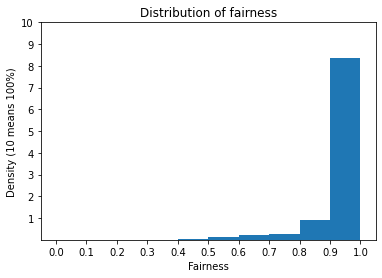

In [19]:
# Distribution of fairness

print(pd.Series(list(fairness.values())).describe())

plt.hist(list(fairness.values()), bins=10, range=(0, 1), density=True)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.title("Distribution of fairness")
plt.xlabel("Fairness")
plt.ylabel("Density (10 means 100%)")
plt.show()

count    5881.000000
mean        0.936197
std         0.092771
min         0.319962
25%         0.930835
50%         0.963418
75%         0.988162
max         1.000000
dtype: float64


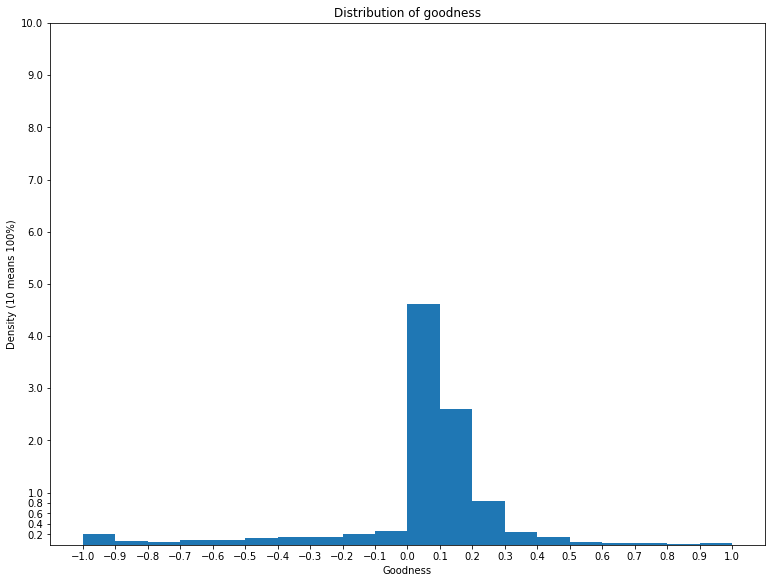

In [20]:
# Distribution of goodness

print(pd.Series(list(fairness.values())).describe())

plt.figure(figsize=(12.8, 9.6))
plt.hist(list(goodness.values()), bins=20, range=(-1, 1), density=True)
plt.xticks([-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,
            0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.title("Distribution of goodness")
plt.xlabel("Goodness")
plt.ylabel("Density (10 means 100%)")
plt.show()

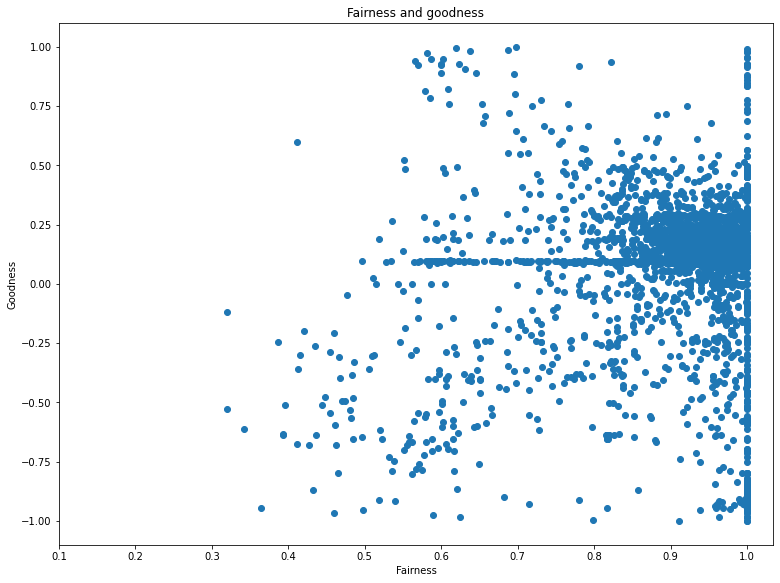

In [21]:
plt.figure(figsize=(12.8, 9.6))

plt.scatter(list(fairness.values()), list(goodness.values()))
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.title("Fairness and goodness")
plt.xlabel("Fairness")
plt.ylabel("Goodness")
plt.show()

We can say that people are usually "benign": They usually rate fairly and get rated mildly positively.

Fairness and goodness simply measures compliance to the society's norms. Here, the market has a benign characteristic (see distribution of ratings in Chapter I). **These metrics are useful because of the benign character of the market and the caution of people.**

**True value of a rating: FxG score**

FxG = Source's fairness * Dest's goodness

This simple and intuitive score is a very good estimator of edge weights as well. See (Kumar, Spezzano, et al. 2016)

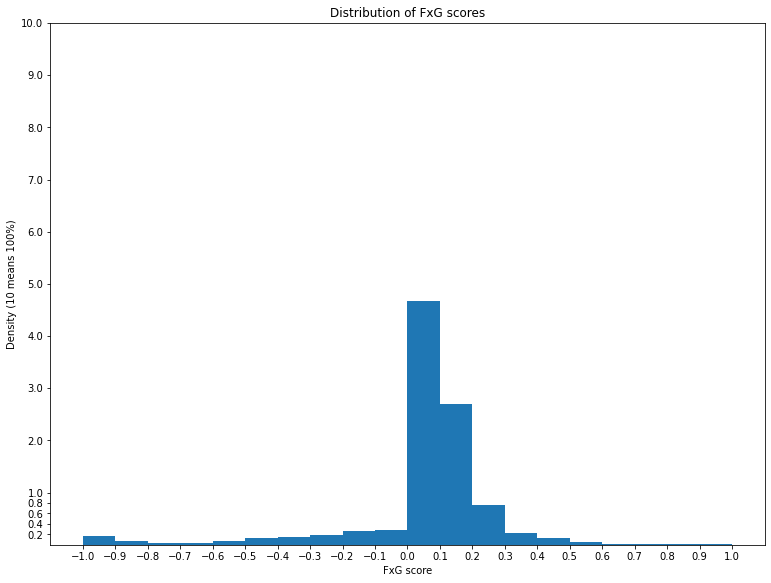

In [22]:
# Distribution of FxG scores

plt.figure(figsize=(12.8, 9.6))
plt.hist(np.array(list(goodness.values())) * np.array(list(fairness.values())), bins=20, range=(-1, 1), density=True)
plt.xticks([-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,
            0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.title("Distribution of FxG scores")
plt.xlabel("FxG score")
plt.ylabel("Density (10 means 100%)")
plt.show()

### Fairness, Goodness, and Centrality - How influence affects fairness and goodness

We expect it does not corrupt, since someone who is consistently rated negatively lowers their chance to be preferred later on. However, fraud rings might try to improve their friends' reputation. Let's visually test our hypothesis in the EDA level, we'll dive deeper on that in the next notebook.

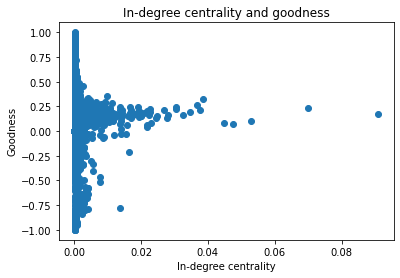

In [23]:
# In-degree centrality and goodness
from networkx.algorithms.centrality import in_degree_centrality

in_degree_cent = in_degree_centrality(G)

plt.scatter(list(in_degree_cent.values()), list(goodness.values()))
plt.title("In-degree centrality and goodness")
plt.ylabel("Goodness")
plt.xlabel("In-degree centrality")
plt.show()

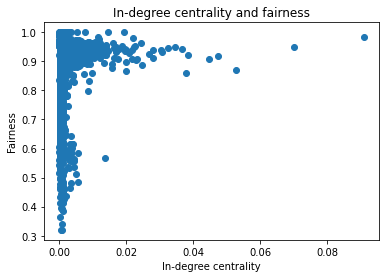

In [24]:
# In-degree centrality and fairness
from networkx.algorithms.centrality import in_degree_centrality

in_degree_cent = in_degree_centrality(G)

plt.scatter(list(in_degree_cent.values()), list(fairness.values()))
plt.title("In-degree centrality and fairness")
plt.ylabel("Fairness")
plt.xlabel("In-degree centrality")
plt.show()

People with high in-degree centrality are usually "good and fair" people, however several nodes with high in-degree centrality but low fairness/goodness need attention

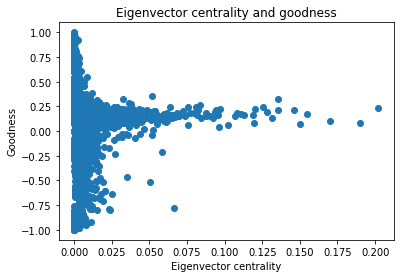

In [25]:
# Eigenvector centrality and goodness
from networkx.algorithms.centrality import eigenvector_centrality

eig_cent = eigenvector_centrality(G)

plt.scatter(list(eig_cent.values()), list(goodness.values()))
plt.title("Eigenvector centrality and goodness")
plt.ylabel("Goodness")
plt.xlabel("Eigenvector centrality")
plt.show()

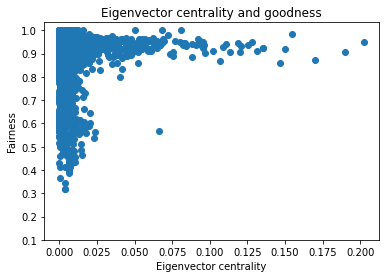

In [26]:
# Eigenvector centrality and fairness
from networkx.algorithms.centrality import eigenvector_centrality

eig_cent = eigenvector_centrality(G)

plt.scatter(list(eig_cent.values()), list(fairness.values()))
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.title("Eigenvector centrality and goodness")
plt.ylabel("Fairness")
plt.xlabel("Eigenvector centrality")
plt.show()

Eigenvector Centrality (EC) quantifies the influence you gain from knowing high-profile people like Jeff Bezos, Ferit Sahenk etc. In the analogy here, high-profile people are the nodes with higher centrality. EC can also be used to estimate helpfulness in trust networks. (See De Meo, Musial-Gabrys et al., 2017)

Here people with higher EC are usually good and fair, with several exceptions. (Can they be the leaders of fraud rings? We'll see that in the next notebook)

**Note: In NetworkX, EC for directed graphs is calculated using in-edges by default**

### Assortativity - Do birds of a feather flock together?

Homophily is the tendence of a node to connect with nodes that are similar to them. In a fraud ring, we would expect some degree of homophily since fraud rings mostly consist of fraudster nodes.

Here we will calculate assortativity coefficients for each node, based on their goodness values. The metric is inspired from (Thedchanamoorty et al., 2014), but I retouched it a little bit.

Both in-neighbors and out-neighbors will be counted here, since in either case we assume there should be a reason to rate/get rated by a particular node among more than 5k nodes. This assumption is safe because of the benign character of the market.

**Naive node assortativity:**
- Range: [0, 1]
- "Score of good people hanging out with good people or vice versa"
- For each node's neighbors:
    - Naive Goodness = `int(Goodness(Node) >= 0)`
    - Naive Node assortativity = `sum(int(Naive_Goodness(Neighbor i) == Naive_Goodness(Node)) / degree(Node)`

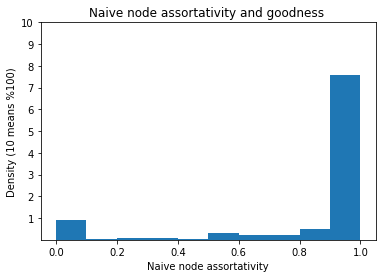

In [37]:
from sna_bitcoin_otc.utils.algorithms import naive_node_assortativity

plt.hist(list(naive_node_assortativity(G, goodness).values()), density=True)
plt.title("Naive node assortativity and goodness ")
plt.ylabel("Density (10 means %100)")
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel("Naive node assortativity")
plt.show()

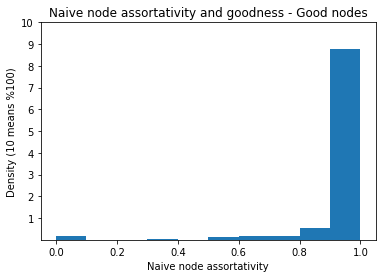

In [36]:
from sna_bitcoin_otc.utils.algorithms import naive_node_assortativity_pos_neg

plt.hist(list(naive_node_assortativity_pos_neg(G, goodness, pos=True).values()), density=True)
plt.title("Naive node assortativity and goodness - Good nodes")
plt.ylabel("Density (10 means %100)")
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel("Naive node assortativity")
plt.show()

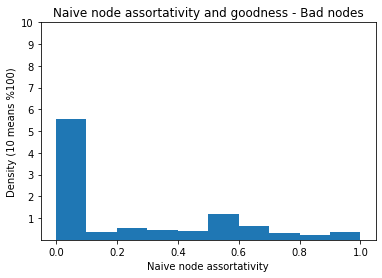

In [38]:
from sna_bitcoin_otc.utils.algorithms import naive_node_assortativity_pos_neg

plt.hist(list(naive_node_assortativity_pos_neg(G, goodness, pos=False).values()), density=True)
plt.title("Naive node assortativity and goodness - Bad nodes")
plt.ylabel("Density (10 means %100)")
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel("Naive node assortativity")
plt.show()